In [20]:
import pandas as pd
import numpy as np

In [21]:
logs = pd.read_csv("logs_final6000.csv")
transactions = pd.read_csv("transactions_final6000.csv")
members = pd.read_csv("members_final6000.csv")

### LOGS PREPROCCESSING

In [22]:
logs.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,k6eJ3xRzpnAkLsdWp4fFsiN7loavl/agmfrUdvFCJQI=,20170310,22,11,7,1,0,36,2344.100
1,mDKq91Oh/6Xf9M8diUwkngAmESHOodRWfPYICPb5pCk=,20170303,11,4,2,3,13,23,4355.847
2,gXdMWngaV19y8Q58XauCO7K9eImYEuAj1omfKWo16j0=,20170326,32,6,5,4,93,89,26062.316
3,HvF3jxKYlcwLsm8gyaHSFak+GG0rezgvHeZQl4Us4Ig=,20170325,34,7,2,3,66,89,14213.393
4,SWeWAl/aiYcfcc6QMsKD2A31LRFPG9kFOBKfgwSHHv8=,20170310,10,3,3,1,24,31,6905.749


In [23]:
logs['songs_total'] = logs.num_100 + logs.num_985 + logs.num_75 + logs.num_50 + logs.num_25

In [24]:
def parse_date(df, column_name='date'):
    years=[]
    months=[]
    days=[]

    list_of_dates = df[column_name].tolist()
    for i in range(len(list_of_dates)):
        years.append(str(list_of_dates[i])[0:4])
        months.append(str(list_of_dates[i])[4:6])
        days.append(str(list_of_dates[i])[6:8])

    df['years'] = years
    df['months'] = months
    df['days'] = days

In [25]:
parse_date(logs)
logs.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,songs_total,years,months,days
0,k6eJ3xRzpnAkLsdWp4fFsiN7loavl/agmfrUdvFCJQI=,20170310,22,11,7,1,0,36,2344.100,41,2017,03,10
1,mDKq91Oh/6Xf9M8diUwkngAmESHOodRWfPYICPb5pCk=,20170303,11,4,2,3,13,23,4355.847,33,2017,03,03
2,gXdMWngaV19y8Q58XauCO7K9eImYEuAj1omfKWo16j0=,20170326,32,6,5,4,93,89,26062.316,140,2017,03,26
3,HvF3jxKYlcwLsm8gyaHSFak+GG0rezgvHeZQl4Us4Ig=,20170325,34,7,2,3,66,89,14213.393,112,2017,03,25
4,SWeWAl/aiYcfcc6QMsKD2A31LRFPG9kFOBKfgwSHHv8=,20170310,10,3,3,1,24,31,6905.749,41,2017,03,10


In [26]:
# Calculating column values

# num_ops = ['sum', 'avg', 'user_total', 'max', 'min']
def nums_ops(df, column_name, operation):
    
    if operation == 'user_total':
        return df.groupby(['msno']).size()
    
    users_values = df.groupby(['msno'])
    if operation == 'sum':
        return users_values.agg({column_name: np.sum})
    elif operation == 'avg':
        return users_values.agg({column_name: np.average})
    elif operation == 'max':
        return users_values.agg({column_name: np.max})
    elif operation == 'min':
        return users_values.agg({column_name: np.min})

In [27]:
def percentages(df,column1, column2):
    
    column1 = df[column1]
    column2 = df[column2]
    
    return column1/column2

In [28]:
def get_avg_logs_per_month(num_of_month, num_og_logs):
    return num_of_month/num_of_logs

In [29]:
def unique_month(df):
    month_count = (df['months'].astype(str) + df['years'].astype(str)).nunique()
    return month_count

In [30]:
def month_count(df):
    months = []
    users = df.groupby(['msno'])
    
    for user in users.groups:
        user_df = df[df['msno'] == user]
        months_unq = unique_month(user_df)
        months.append(months_unq)
    return months

In [31]:
# Date preproccessing
import datetime


def process_dates(df, column_name):
    df[column_name] = df[column_name].astype(str)
    df[column_name] = pd.to_datetime(df[column_name], format='%Y%M%d')
    days = []
    for i in range(df.shape[0]):
        sec = (df[column_name][i] - datetime.datetime(1970,1,1)).total_seconds()/(60*60*12)
        days.append(int(sec))
    df[column_name] = days
    df['days_diff'] = list(map(abs, df[column_name].diff()))
    avg_days_diff = nums_ops(df, 'days_diff', 'avg')
    max_days_diff = nums_ops(df, 'days_diff', 'max')
    min_days_diff = nums_ops(df, 'days_diff', 'min')
    
    return [avg_days_diff, max_days_diff, min_days_diff]

In [32]:
# date_type = ['month', 'day']

# day - week_start, middle, week_end
# month - winter, spring, summer, autumn
def date_to_cat(df, column_name, date_type):
    bins = []
    values = []
    if date_type == 'day':
        bins = [1, 15, 31]
    elif date_type == 'month':
        bins = [0, 4, 8, 12]
    dates = df[column_name].astype(int).values
    for date in dates:
        if date_type == 'day':
            if date < 11:
                values.append(1)
            elif date >= 11 and date < 21:
                values.append(2)
            else:
                values.append(3)
        elif date_type == 'month':
            if date < 3 or date == 12:
                values.append(1)
            elif date >= 3 and date < 6:
                values.append(2)
            elif date >= 6 and date < 9:
                values.append(3)
            else:
                values.append(4)
    return values

In [33]:
logs.days = date_to_cat(logs, 'days', 'day')
logs.months = date_to_cat(logs, 'months', 'month')
logs.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,songs_total,years,months,days
0,k6eJ3xRzpnAkLsdWp4fFsiN7loavl/agmfrUdvFCJQI=,20170310,22,11,7,1,0,36,2344.100,41,2017,2,1
1,mDKq91Oh/6Xf9M8diUwkngAmESHOodRWfPYICPb5pCk=,20170303,11,4,2,3,13,23,4355.847,33,2017,2,1
2,gXdMWngaV19y8Q58XauCO7K9eImYEuAj1omfKWo16j0=,20170326,32,6,5,4,93,89,26062.316,140,2017,2,3
3,HvF3jxKYlcwLsm8gyaHSFak+GG0rezgvHeZQl4Us4Ig=,20170325,34,7,2,3,66,89,14213.393,112,2017,2,3
4,SWeWAl/aiYcfcc6QMsKD2A31LRFPG9kFOBKfgwSHHv8=,20170310,10,3,3,1,24,31,6905.749,41,2017,2,1


In [34]:
logs_linear = pd.DataFrame()
logs_linear['num_of_logs'] = nums_ops(logs, '', 'user_total')
logs_linear['sum_num25'] = nums_ops(logs, 'num_25', 'sum')
logs_linear['avg_num25'] = nums_ops(logs, 'num_25', 'avg')
logs_linear['sum_num50'] = nums_ops(logs, 'num_50', 'sum')
logs_linear['avg_num50'] = nums_ops(logs, 'num_50', 'avg')
logs_linear['sum_num75'] = nums_ops(logs, 'num_75', 'sum')
logs_linear['avg_num75'] = nums_ops(logs, 'num_75', 'avg')
logs_linear['sum_num985'] = nums_ops(logs, 'num_985', 'sum')
logs_linear['avg_num985'] = nums_ops(logs, 'num_985', 'avg')
logs_linear['sum_num100'] = nums_ops(logs, 'num_100', 'sum')
logs_linear['avg_num100'] = nums_ops(logs, 'num_100', 'avg')
logs_linear['sum_num_unq'] = nums_ops(logs, 'num_unq', 'sum')
logs_linear['avg_num_unq'] = nums_ops(logs, 'num_unq', 'avg')
logs_linear['sum_total_secs'] = nums_ops(logs, 'total_secs', 'sum')
logs_linear['avg_total_secs'] = nums_ops(logs, 'total_secs', 'avg')
logs_linear['sum_total_songs'] = nums_ops(logs, 'songs_total', 'sum')
logs_linear['avg_total_songs'] = nums_ops(logs, 'songs_total', 'avg')
logs_linear['perc_of_accidentally_songs'] = percentages(logs_linear, 'sum_num25', 'sum_total_songs')
logs_linear['perc_of_favourite_songs'] = percentages(logs_linear, 'sum_num100', 'sum_total_songs')
logs_linear['avg_songs_per_month'] = logs_linear['sum_total_songs']/month_count(logs)
processed_dates = process_dates(logs, 'date')
logs_linear['avg_days_diff'] = processed_dates[0]
logs_linear['max_days_diff'] = processed_dates[1]
logs_linear['min_days_diff'] = processed_dates[2]
logs.days = logs.days.astype(int)
logs_linear['most_popular_days'] = nums_ops(logs, 'days', 'max')
logs_linear['least_popular_days'] = nums_ops(logs, 'days', 'min')
logs.months = logs.months.astype(int)
logs_linear['most_popular_season'] = nums_ops(logs, 'months', 'max')
logs_linear['least_popular_season'] = nums_ops(logs, 'months', 'min')

# transforming groupping index into column
logs_linear.reset_index(drop=True, inplace=True)
logs_linear['msno'] = logs.msno.unique()

In [35]:
logs_linear.fillna(0, inplace=True)
logs_linear.head()

,num_of_logs,sum_num25,avg_num25,sum_num50,avg_num50,sum_num75,avg_num75,sum_num985,avg_num985,sum_num100,...,perc_of_favourite_songs,avg_songs_per_month,avg_days_diff,max_days_diff,min_days_diff,most_popular_days,least_popular_days,most_popular_season,least_popular_season,msno
0,11,112,10.181818,31,2.818182,23,2.090909,30,2.727273,207,...,0.513648,403.0,23.636364,56.0,2.0,3,1,2,2,k6eJ3xRzpnAkLsdWp4fFsiN7loavl/agmfrUdvFCJQI=
1,17,91,5.352941,59,3.470588,46,2.705882,15,0.882353,480,...,0.694645,691.0,22.941176,54.0,2.0,3,1,2,2,mDKq91Oh/6Xf9M8diUwkngAmESHOodRWfPYICPb5pCk=
2,16,45,2.812500,9,0.562500,8,0.500000,8,0.500000,110,...,0.611111,180.0,17.750000,48.0,2.0,3,1,2,2,gXdMWngaV19y8Q58XauCO7K9eImYEuAj1omfKWo16j0=
3,2,9,4.500000,0,0.000000,0,0.000000,1,0.500000,16,...,0.615385,26.0,11.000000,22.0,0.0,2,2,2,2,HvF3jxKYlcwLsm8gyaHSFak+GG0rezgvHeZQl4Us4Ig=
4,17,26,1.529412,4,0.235294,4,0.235294,12,0.705882,106,...,0.697368,152.0,21.294118,50.0,2.0,3,1,2,2,SWeWAl/aiYcfcc6QMsKD2A31LRFPG9kFOBKfgwSHHv8=


In [36]:
logs_linear.most_popular_days = logs_linear.most_popular_days.astype('category')
logs_linear.least_popular_season = logs_linear.least_popular_season.astype('category')
logs_linear.least_popular_days = logs_linear.least_popular_days.astype('category')
logs_linear.most_popular_season = logs_linear.most_popular_season.astype('category')

logs_trees = logs_linear.copy()
logs_trees.to_csv('logs_trees6000.csv', index=False)

In [37]:
logs_linear = pd.get_dummies(logs_linear.drop(['msno'], axis=1))
logs_linear['msno'] = logs_trees.msno
logs_linear.head()

,num_of_logs,sum_num25,avg_num25,sum_num50,avg_num50,sum_num75,avg_num75,sum_num985,avg_num985,sum_num100,...,min_days_diff,most_popular_days_1,most_popular_days_2,most_popular_days_3,least_popular_days_1,least_popular_days_2,least_popular_days_3,most_popular_season_2,least_popular_season_2,msno
0,11,112,10.181818,31,2.818182,23,2.090909,30,2.727273,207,...,2.0,0,0,1,1,0,0,1,1,k6eJ3xRzpnAkLsdWp4fFsiN7loavl/agmfrUdvFCJQI=
1,17,91,5.352941,59,3.470588,46,2.705882,15,0.882353,480,...,2.0,0,0,1,1,0,0,1,1,mDKq91Oh/6Xf9M8diUwkngAmESHOodRWfPYICPb5pCk=
2,16,45,2.812500,9,0.562500,8,0.500000,8,0.500000,110,...,2.0,0,0,1,1,0,0,1,1,gXdMWngaV19y8Q58XauCO7K9eImYEuAj1omfKWo16j0=
3,2,9,4.500000,0,0.000000,0,0.000000,1,0.500000,16,...,0.0,0,1,0,0,1,0,1,1,HvF3jxKYlcwLsm8gyaHSFak+GG0rezgvHeZQl4Us4Ig=
4,17,26,1.529412,4,0.235294,4,0.235294,12,0.705882,106,...,2.0,0,0,1,1,0,0,1,1,SWeWAl/aiYcfcc6QMsKD2A31LRFPG9kFOBKfgwSHHv8=


In [38]:
logs_linear.dtypes

num_of_logs                     int64
sum_num25                       int64
avg_num25                     float64
sum_num50                       int64
avg_num50                     float64
sum_num75                       int64
avg_num75                     float64
sum_num985                      int64
avg_num985                    float64
sum_num100                      int64
avg_num100                    float64
sum_num_unq                     int64
avg_num_unq                   float64
sum_total_secs                float64
avg_total_secs                float64
sum_total_songs                 int64
avg_total_songs               float64
perc_of_accidentally_songs    float64
perc_of_favourite_songs       float64
avg_songs_per_month           float64
avg_days_diff                 float64
max_days_diff                 float64
min_days_diff                 float64
most_popular_days_1             uint8
most_popular_days_2             uint8
most_popular_days_3             uint8
least_popula

In [39]:
logs_linear.to_csv('logs_linear6000.csv', index=False)

### MEMBERS PREPROCCESSING

In [40]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time
0,7Bx3zw0JFFwCXjkWgqhMxnQQLzy7Idmc+J1qXU8GhAY=,13,25,female,9,20141130
1,OFhJwMVNuJKYC6MNLmCulVSJatkQ1ZexipKpyujQa4c=,5,0,female,9,20141130
2,OFjgd4O5aCzXBFosKhGhqB8bKEgtV/9RQSN28yPtGHk=,1,0,NaN,7,20130116
3,G7Zl2XAspwOaYJLlKK3FLmgypn3qYeGFKC/9WbczS+0=,4,43,female,7,20110321
4,7v4BtQAEWazr9JYq5iqbNtWp0SNTNgKTBNZ0z+9CGEM=,15,21,female,3,20160321


In [41]:
parse_date(members, 'registration_init_time')

In [42]:
members.drop(['registration_init_time', 'years'], axis=1, inplace=True)
members.head()

,msno,city,bd,gender,registered_via,months,days
0,7Bx3zw0JFFwCXjkWgqhMxnQQLzy7Idmc+J1qXU8GhAY=,13,25,female,9,11,30
1,OFhJwMVNuJKYC6MNLmCulVSJatkQ1ZexipKpyujQa4c=,5,0,female,9,11,30
2,OFjgd4O5aCzXBFosKhGhqB8bKEgtV/9RQSN28yPtGHk=,1,0,NaN,7,01,16
3,G7Zl2XAspwOaYJLlKK3FLmgypn3qYeGFKC/9WbczS+0=,4,43,female,7,03,21
4,7v4BtQAEWazr9JYq5iqbNtWp0SNTNgKTBNZ0z+9CGEM=,15,21,female,3,03,21


In [43]:
members.days = date_to_cat(members, 'days', 'day')
members['season'] = date_to_cat(members, 'months', 'month')
members.drop(['months'], axis=1, inplace=True)
members.head()

,msno,city,bd,gender,registered_via,days,season
0,7Bx3zw0JFFwCXjkWgqhMxnQQLzy7Idmc+J1qXU8GhAY=,13,25,female,9,3,4
1,OFhJwMVNuJKYC6MNLmCulVSJatkQ1ZexipKpyujQa4c=,5,0,female,9,3,4
2,OFjgd4O5aCzXBFosKhGhqB8bKEgtV/9RQSN28yPtGHk=,1,0,NaN,7,2,1
3,G7Zl2XAspwOaYJLlKK3FLmgypn3qYeGFKC/9WbczS+0=,4,43,female,7,3,2
4,7v4BtQAEWazr9JYq5iqbNtWp0SNTNgKTBNZ0z+9CGEM=,15,21,female,3,3,2


In [44]:
members.loc[members.bd < 12, 'bd'] = None
members.loc[members.bd > 70, 'bd'] = None
members.head()

,msno,city,bd,gender,registered_via,days,season
0,7Bx3zw0JFFwCXjkWgqhMxnQQLzy7Idmc+J1qXU8GhAY=,13,25.0,female,9,3,4
1,OFhJwMVNuJKYC6MNLmCulVSJatkQ1ZexipKpyujQa4c=,5,NaN,female,9,3,4
2,OFjgd4O5aCzXBFosKhGhqB8bKEgtV/9RQSN28yPtGHk=,1,NaN,NaN,7,2,1
3,G7Zl2XAspwOaYJLlKK3FLmgypn3qYeGFKC/9WbczS+0=,4,43.0,female,7,3,2
4,7v4BtQAEWazr9JYq5iqbNtWp0SNTNgKTBNZ0z+9CGEM=,15,21.0,female,3,3,2


In [45]:
members.loc[members.gender == 'male', 'gender'] = 0
members.loc[members.gender == 'female', 'gender'] = 1
members.gender.astype(float)
members.head()

,msno,city,bd,gender,registered_via,days,season
0,7Bx3zw0JFFwCXjkWgqhMxnQQLzy7Idmc+J1qXU8GhAY=,13,25.0,1,9,3,4
1,OFhJwMVNuJKYC6MNLmCulVSJatkQ1ZexipKpyujQa4c=,5,NaN,1,9,3,4
2,OFjgd4O5aCzXBFosKhGhqB8bKEgtV/9RQSN28yPtGHk=,1,NaN,NaN,7,2,1
3,G7Zl2XAspwOaYJLlKK3FLmgypn3qYeGFKC/9WbczS+0=,4,43.0,1,7,3,2
4,7v4BtQAEWazr9JYq5iqbNtWp0SNTNgKTBNZ0z+9CGEM=,15,21.0,1,3,3,2


In [46]:
members.dtypes

msno               object
city                int64
bd                float64
gender             object
registered_via      int64
days                int64
season              int64
dtype: object

In [47]:
members_boost = members.copy()
members.head()
members_boost.to_csv('members_boost6000.csv', index=False)

In [48]:
members_trees = members_boost.copy()
members_trees.gender = members_trees.gender.fillna('nan')
members_trees.city = members_trees.city.fillna('nan')
members_trees.registered_via = members_trees.registered_via.fillna('nan')
members_trees.season = members_trees.season.fillna('nan')
members_trees.days = members_trees.days.fillna('nan')
members_trees.bd = members_trees.bd.fillna(-1)
members_trees.bd = members_trees.bd.astype(int)
members_trees.loc[members_trees.gender == 'nan', 'gender'] = 2
members_trees.head()

,msno,city,bd,gender,registered_via,days,season
0,7Bx3zw0JFFwCXjkWgqhMxnQQLzy7Idmc+J1qXU8GhAY=,13,25,1,9,3,4
1,OFhJwMVNuJKYC6MNLmCulVSJatkQ1ZexipKpyujQa4c=,5,-1,1,9,3,4
2,OFjgd4O5aCzXBFosKhGhqB8bKEgtV/9RQSN28yPtGHk=,1,-1,2,7,2,1
3,G7Zl2XAspwOaYJLlKK3FLmgypn3qYeGFKC/9WbczS+0=,4,43,1,7,3,2
4,7v4BtQAEWazr9JYq5iqbNtWp0SNTNgKTBNZ0z+9CGEM=,15,21,1,3,3,2


In [49]:
members_trees.head()

,msno,city,bd,gender,registered_via,days,season
0,7Bx3zw0JFFwCXjkWgqhMxnQQLzy7Idmc+J1qXU8GhAY=,13,25,1,9,3,4
1,OFhJwMVNuJKYC6MNLmCulVSJatkQ1ZexipKpyujQa4c=,5,-1,1,9,3,4
2,OFjgd4O5aCzXBFosKhGhqB8bKEgtV/9RQSN28yPtGHk=,1,-1,2,7,2,1
3,G7Zl2XAspwOaYJLlKK3FLmgypn3qYeGFKC/9WbczS+0=,4,43,1,7,3,2
4,7v4BtQAEWazr9JYq5iqbNtWp0SNTNgKTBNZ0z+9CGEM=,15,21,1,3,3,2


In [50]:
members_trees.to_csv('members_trees6000.csv', index=False)

In [51]:
members_linear = members.copy()
members_linear.bd = members_linear.bd.fillna(members_linear.bd.mean())
members_linear.bd = members_linear.bd.astype(int)
dummies = pd.get_dummies(members, columns=['city', 'gender','registered_via', 'season', 'days'])
dummies['bd'] = members_linear.bd
dummies['msno'] = members_linear.msno
members_linear = dummies
members_linear.head()

,msno,bd,city_1,city_3,city_4,city_5,city_6,city_7,city_8,city_9,...,registered_via_7,registered_via_9,registered_via_13,season_1,season_2,season_3,season_4,days_1,days_2,days_3
0,7Bx3zw0JFFwCXjkWgqhMxnQQLzy7Idmc+J1qXU8GhAY=,25,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
1,OFhJwMVNuJKYC6MNLmCulVSJatkQ1ZexipKpyujQa4c=,28,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
2,OFjgd4O5aCzXBFosKhGhqB8bKEgtV/9RQSN28yPtGHk=,28,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
3,G7Zl2XAspwOaYJLlKK3FLmgypn3qYeGFKC/9WbczS+0=,43,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
4,7v4BtQAEWazr9JYq5iqbNtWp0SNTNgKTBNZ0z+9CGEM=,21,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [52]:
members_linear.to_csv('members_linear6000.csv', index=False)

### TRANSACTIONS PREPROCCESSING

In [53]:
transactions.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,+/w1UrZwyka4C9oNH3+Q8fUf3fD8R3EwWrx57ODIsqk=,36,30,180,180,1,20170329,20170331,1
1,+mM0jyxAgO+WXyjjj1T0lIs4vYbG0zScKm/ifZ6sQYc=,41,30,149,149,1,20170319,20170419,0
2,1jvspS1PHcDrla+o7vzQNF5EwnljbIzPA74amszByH0=,32,180,536,536,0,20170214,20170816,0
3,2itkk6/ZKx1yxLVaZveY+852icG56/XS4OjQhWYjCxE=,41,30,149,149,1,20160821,20170521,0
4,4bUWgWmMP0KMfLFLK7kaMg+FNvqT4uSwWvRBOaHqjNE=,36,30,180,180,0,20170306,20170408,0


In [54]:
user_id = transactions.msno.unique()[12]
user = transactions[transactions.msno == user_id]
user

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
12,EuuT43Y50xnjS3dk1LfabPQZpFfz6PXLYAZsG6RWbpM=,41,30,99,99,1,20170309,20170309,1
5527,EuuT43Y50xnjS3dk1LfabPQZpFfz6PXLYAZsG6RWbpM=,41,30,99,99,1,20170305,20170405,0
7916,EuuT43Y50xnjS3dk1LfabPQZpFfz6PXLYAZsG6RWbpM=,41,30,100,100,1,20170309,20170408,0


In [55]:
# dtype = ['transaction', 'expire']
def parse_transaction_dates(df, column_name='membership_expire_date', dtype='expire'):
    years=[]
    months=[]
    days=[]

    list_of_dates = df[column_name].tolist()
    for i in range(len(list_of_dates)):
        years.append(str(list_of_dates[i])[0:4])
        months.append(str(list_of_dates[i])[4:6])
        days.append(str(list_of_dates[i])[6:8])
    if dtype == 'expire':
        df['expire_years'] = years
        df['expire_months'] = months
        df['expire_days'] = days
    elif dtype == 'transaction':
        df['transaction_years'] = years
        df['transaction_months'] = months
        df['transaction_days'] = days

In [56]:
parse_transaction_dates(transactions, 'transaction_date', 'transaction')
parse_transaction_dates(transactions)
transactions.drop(['transaction_years', 'expire_years'], axis=1, inplace=True)
transactions.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,transaction_months,transaction_days,expire_months,expire_days
0,+/w1UrZwyka4C9oNH3+Q8fUf3fD8R3EwWrx57ODIsqk=,36,30,180,180,1,20170329,20170331,1,03,29,03,31
1,+mM0jyxAgO+WXyjjj1T0lIs4vYbG0zScKm/ifZ6sQYc=,41,30,149,149,1,20170319,20170419,0,03,19,04,19
2,1jvspS1PHcDrla+o7vzQNF5EwnljbIzPA74amszByH0=,32,180,536,536,0,20170214,20170816,0,02,14,08,16
3,2itkk6/ZKx1yxLVaZveY+852icG56/XS4OjQhWYjCxE=,41,30,149,149,1,20160821,20170521,0,08,21,05,21
4,4bUWgWmMP0KMfLFLK7kaMg+FNvqT4uSwWvRBOaHqjNE=,36,30,180,180,0,20170306,20170408,0,03,06,04,08


In [57]:
transactions.transaction_days = date_to_cat(transactions, 'transaction_days', 'day')
transactions.transaction_months = date_to_cat(transactions, 'transaction_months', 'month')
transactions.expire_days = date_to_cat(transactions, 'expire_days', 'day')
transactions.expire_months = date_to_cat(transactions, 'expire_months', 'month')
members.head()

,msno,city,bd,gender,registered_via,days,season
0,7Bx3zw0JFFwCXjkWgqhMxnQQLzy7Idmc+J1qXU8GhAY=,13,25.0,1,9,3,4
1,OFhJwMVNuJKYC6MNLmCulVSJatkQ1ZexipKpyujQa4c=,5,NaN,1,9,3,4
2,OFjgd4O5aCzXBFosKhGhqB8bKEgtV/9RQSN28yPtGHk=,1,NaN,NaN,7,2,1
3,G7Zl2XAspwOaYJLlKK3FLmgypn3qYeGFKC/9WbczS+0=,4,43.0,1,7,3,2
4,7v4BtQAEWazr9JYq5iqbNtWp0SNTNgKTBNZ0z+9CGEM=,15,21.0,1,3,3,2


In [58]:
def value_todate(df, column_name):
    values = df[column_name].astype(str)
    dates = pd.to_datetime(values, format='%Y%M%d')
    days = []
    for i in range(df.shape[0]):
        sec = (dates[i] - datetime.datetime(1970,1,1)).total_seconds()/(60*60*12)
        days.append(int(sec))
    return days


trans_dates = value_todate(transactions, "transaction_date")
exp_dates = value_todate(transactions, "membership_expire_date")
transactions['left_payment_seconds'] = [x - y for x, y in zip(exp_dates, trans_dates)]
transactions.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,transaction_months,transaction_days,expire_months,expire_days,left_payment_seconds
0,+/w1UrZwyka4C9oNH3+Q8fUf3fD8R3EwWrx57ODIsqk=,36,30,180,180,1,20170329,20170331,1,2,3,2,3,4
1,+mM0jyxAgO+WXyjjj1T0lIs4vYbG0zScKm/ifZ6sQYc=,41,30,149,149,1,20170319,20170419,0,2,2,2,2,0
2,1jvspS1PHcDrla+o7vzQNF5EwnljbIzPA74amszByH0=,32,180,536,536,0,20170214,20170816,0,1,2,3,2,4
3,2itkk6/ZKx1yxLVaZveY+852icG56/XS4OjQhWYjCxE=,41,30,149,149,1,20160821,20170521,0,3,3,2,3,732
4,4bUWgWmMP0KMfLFLK7kaMg+FNvqT4uSwWvRBOaHqjNE=,36,30,180,180,0,20170306,20170408,0,2,1,2,1,4


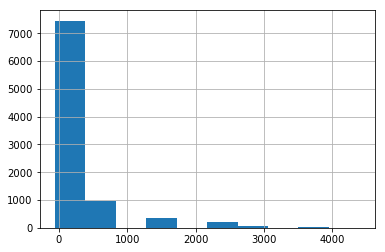

In [59]:
import matplotlib.pyplot as plt

# should take left seconds against days
transactions.left_payment_seconds[transactions.left_payment_seconds > -500].hist()
plt.show()

In [60]:
transactions.loc[transactions.payment_plan_days == 30, 'payment_plan_days'] = 0
transactions.loc[transactions.payment_plan_days == 31, 'payment_plan_days'] = 0
transactions.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,transaction_months,transaction_days,expire_months,expire_days,left_payment_seconds
0,+/w1UrZwyka4C9oNH3+Q8fUf3fD8R3EwWrx57ODIsqk=,36,0,180,180,1,20170329,20170331,1,2,3,2,3,4
1,+mM0jyxAgO+WXyjjj1T0lIs4vYbG0zScKm/ifZ6sQYc=,41,0,149,149,1,20170319,20170419,0,2,2,2,2,0
2,1jvspS1PHcDrla+o7vzQNF5EwnljbIzPA74amszByH0=,32,180,536,536,0,20170214,20170816,0,1,2,3,2,4
3,2itkk6/ZKx1yxLVaZveY+852icG56/XS4OjQhWYjCxE=,41,0,149,149,1,20160821,20170521,0,3,3,2,3,732
4,4bUWgWmMP0KMfLFLK7kaMg+FNvqT4uSwWvRBOaHqjNE=,36,0,180,180,0,20170306,20170408,0,2,1,2,1,4


In [61]:
trans_trees = pd.DataFrame()
trans_trees['num_of_transactions'] = nums_ops(transactions, '', 'user_total')
trans_trees['most_popular_payment_id'] = nums_ops(transactions, 'payment_method_id', 'max')
trans_trees['extra_payment_plans_total'] = nums_ops(transactions, 'payment_plan_days', 'sum')

trans_copy = transactions.copy()
trans_copy.loc[trans_copy.payment_plan_days != 0, 'payment_plan_days'] = 1
all_payments = nums_ops(trans_copy, 'payment_plan_days', 'sum')
trans_trees['extra_payment_plans_count'] = nums_ops(trans_copy, 'payment_plan_days', 'sum')

trans_trees['avg_plan_list_price'] = nums_ops(transactions, 'plan_list_price', 'avg')
trans_trees['avg_actual_amount_paid'] = nums_ops(transactions, 'actual_amount_paid', 'avg')
trans_trees['is_auto_renew_total'] = nums_ops(transactions, 'is_auto_renew', 'sum')
trans_trees['is_cancel_total'] = nums_ops(transactions, 'is_cancel', 'sum')
trans_trees['left_payment_seconds_total'] = nums_ops(transactions, 'left_payment_seconds', 'sum')
processed_transaction_dates = process_dates(transactions, 'transaction_date')
trans_trees['avg_transaction_days_diff'] = processed_transaction_dates[0]
trans_trees['max_transaction_days_diff'] = processed_transaction_dates[1]
trans_trees['min_transaction_days_diff'] = processed_transaction_dates[2]
processed_expire_dates = process_dates(transactions, 'membership_expire_date')
trans_trees['avg_expire_days_diff'] = processed_expire_dates[0]
trans_trees['max_expire_days_diff'] = processed_expire_dates[1]
trans_trees['min_expire_days_diff'] = processed_expire_dates[2]

transactions.transaction_days = transactions.transaction_days.astype(int)
trans_trees['most_popular_transaction_days'] = nums_ops(transactions, 'transaction_days', 'max')
trans_trees['least_popular_transaction_days'] = nums_ops(transactions, 'transaction_days', 'min')
transactions.transaction_months = transactions.transaction_months.astype(int)
trans_trees['most_popular_transaction_season'] = nums_ops(transactions, 'transaction_months', 'max')
trans_trees['least_popular_transaction_season'] = nums_ops(transactions, 'transaction_months', 'min')

transactions.expire_days = transactions.expire_days.astype(int)
trans_trees['most_popular_expire_days'] = nums_ops(transactions, 'expire_days', 'max')
trans_trees['least_popular_expire_days'] = nums_ops(transactions, 'expire_days', 'min')
transactions.expire_months = transactions.expire_months.astype(int)
trans_trees['most_popular_expire_season'] = nums_ops(transactions, 'expire_months', 'max')
trans_trees['least_popular_expire_season'] = nums_ops(transactions, 'expire_months', 'min')

# transforming groupping index into column
trans_trees.reset_index(drop=True, inplace=True)
trans_trees['msno'] = transactions.msno.unique()

In [62]:
trans_trees.fillna(0, inplace=True)
trans_trees.head()

,num_of_transactions,most_popular_payment_id,extra_payment_plans_total,extra_payment_plans_count,avg_plan_list_price,avg_actual_amount_paid,is_auto_renew_total,is_cancel_total,left_payment_seconds_total,avg_transaction_days_diff,...,min_expire_days_diff,most_popular_transaction_days,least_popular_transaction_days,most_popular_transaction_season,least_popular_transaction_season,most_popular_expire_days,least_popular_expire_days,most_popular_expire_season,least_popular_expire_season,msno
0,1,38,0,0,149.0,149.0,0,0,0,32.000000,...,34.0,1,1,2,2,1,1,2,2,+/w1UrZwyka4C9oNH3+Q8fUf3fD8R3EwWrx57ODIsqk=
1,1,36,0,0,180.0,180.0,1,1,4,0.000000,...,0.0,3,3,2,2,3,3,2,2,+mM0jyxAgO+WXyjjj1T0lIs4vYbG0zScKm/ifZ6sQYc=
2,1,36,0,0,180.0,180.0,1,0,-2,2.000000,...,28.0,1,1,2,2,1,1,2,2,1jvspS1PHcDrla+o7vzQNF5EwnljbIzPA74amszByH0=
3,2,36,0,0,180.0,180.0,2,0,-38,369.000000,...,8.0,3,1,2,2,1,1,2,2,2itkk6/ZKx1yxLVaZveY+852icG56/XS4OjQhWYjCxE=
4,3,41,0,0,129.0,129.0,3,0,40,7.333333,...,6.0,1,1,2,1,2,2,3,2,4bUWgWmMP0KMfLFLK7kaMg+FNvqT4uSwWvRBOaHqjNE=


In [63]:
trans_trees['always_auto_renew'] = trans_trees.num_of_transactions == trans_trees.is_auto_renew_total
trans_trees.head()

,num_of_transactions,most_popular_payment_id,extra_payment_plans_total,extra_payment_plans_count,avg_plan_list_price,avg_actual_amount_paid,is_auto_renew_total,is_cancel_total,left_payment_seconds_total,avg_transaction_days_diff,...,most_popular_transaction_days,least_popular_transaction_days,most_popular_transaction_season,least_popular_transaction_season,most_popular_expire_days,least_popular_expire_days,most_popular_expire_season,least_popular_expire_season,msno,always_auto_renew
0,1,38,0,0,149.0,149.0,0,0,0,32.000000,...,1,1,2,2,1,1,2,2,+/w1UrZwyka4C9oNH3+Q8fUf3fD8R3EwWrx57ODIsqk=,False
1,1,36,0,0,180.0,180.0,1,1,4,0.000000,...,3,3,2,2,3,3,2,2,+mM0jyxAgO+WXyjjj1T0lIs4vYbG0zScKm/ifZ6sQYc=,True
2,1,36,0,0,180.0,180.0,1,0,-2,2.000000,...,1,1,2,2,1,1,2,2,1jvspS1PHcDrla+o7vzQNF5EwnljbIzPA74amszByH0=,True
3,2,36,0,0,180.0,180.0,2,0,-38,369.000000,...,3,1,2,2,1,1,2,2,2itkk6/ZKx1yxLVaZveY+852icG56/XS4OjQhWYjCxE=,True
4,3,41,0,0,129.0,129.0,3,0,40,7.333333,...,1,1,2,1,2,2,3,2,4bUWgWmMP0KMfLFLK7kaMg+FNvqT4uSwWvRBOaHqjNE=,True


In [64]:
trans_trees['payment_id_is_always_auto_renew'] = trans_trees.most_popular_payment_id.astype(str) + trans_trees.always_auto_renew.astype(str)
trans_trees.drop(['always_auto_renew'], axis=1, inplace=True)
trans_trees.head()

,num_of_transactions,most_popular_payment_id,extra_payment_plans_total,extra_payment_plans_count,avg_plan_list_price,avg_actual_amount_paid,is_auto_renew_total,is_cancel_total,left_payment_seconds_total,avg_transaction_days_diff,...,most_popular_transaction_days,least_popular_transaction_days,most_popular_transaction_season,least_popular_transaction_season,most_popular_expire_days,least_popular_expire_days,most_popular_expire_season,least_popular_expire_season,msno,payment_id_is_always_auto_renew
0,1,38,0,0,149.0,149.0,0,0,0,32.000000,...,1,1,2,2,1,1,2,2,+/w1UrZwyka4C9oNH3+Q8fUf3fD8R3EwWrx57ODIsqk=,38False
1,1,36,0,0,180.0,180.0,1,1,4,0.000000,...,3,3,2,2,3,3,2,2,+mM0jyxAgO+WXyjjj1T0lIs4vYbG0zScKm/ifZ6sQYc=,36True
2,1,36,0,0,180.0,180.0,1,0,-2,2.000000,...,1,1,2,2,1,1,2,2,1jvspS1PHcDrla+o7vzQNF5EwnljbIzPA74amszByH0=,36True
3,2,36,0,0,180.0,180.0,2,0,-38,369.000000,...,3,1,2,2,1,1,2,2,2itkk6/ZKx1yxLVaZveY+852icG56/XS4OjQhWYjCxE=,36True
4,3,41,0,0,129.0,129.0,3,0,40,7.333333,...,1,1,2,1,2,2,3,2,4bUWgWmMP0KMfLFLK7kaMg+FNvqT4uSwWvRBOaHqjNE=,41True


In [65]:
trans_trees.to_csv('transactions_trees6000.csv', index=False)

In [66]:
trans_linear = trans_trees.copy()
dummies = pd.get_dummies(trans_linear, columns=['most_popular_payment_id', 'most_popular_transaction_days', 
                                                'least_popular_transaction_days', 'most_popular_transaction_season', 
                                                'least_popular_transaction_season', 'most_popular_expire_days', 
                                                'least_popular_expire_days', 'most_popular_expire_season', 
                                                'least_popular_expire_season', 'payment_id_is_always_auto_renew'])
dummies['num_of_transactions'] = trans_linear.num_of_transactions
dummies['extra_payment_plans_total'] = trans_linear.extra_payment_plans_total
dummies['extra_payment_plans_count'] = trans_linear.extra_payment_plans_count
dummies['avg_plan_list_price'] = trans_linear.avg_plan_list_price
dummies['avg_actual_amount_paid'] = trans_linear.avg_actual_amount_paid
dummies['is_auto_renew_total'] = trans_linear.is_auto_renew_total
dummies['is_cancel_total'] = trans_linear.is_cancel_total
dummies['left_payment_seconds_total'] = trans_linear.left_payment_seconds_total
dummies['avg_transaction_days_diff'] = trans_linear.avg_transaction_days_diff
dummies['max_transaction_days_diff'] = trans_linear.max_transaction_days_diff
dummies['min_transaction_days_diff'] = trans_linear.min_transaction_days_diff
dummies['avg_expire_days_diff'] = trans_linear.avg_expire_days_diff
dummies['max_expire_days_diff'] = trans_linear.max_expire_days_diff
dummies['min_expire_days_diff'] = trans_linear.min_expire_days_diff
dummies['msno'] = trans_linear.msno
trans_linear = dummies
trans_linear.head()

,num_of_transactions,extra_payment_plans_total,extra_payment_plans_count,avg_plan_list_price,avg_actual_amount_paid,is_auto_renew_total,is_cancel_total,left_payment_seconds_total,avg_transaction_days_diff,max_transaction_days_diff,...,payment_id_is_always_auto_renew_36True,payment_id_is_always_auto_renew_37False,payment_id_is_always_auto_renew_37True,payment_id_is_always_auto_renew_38False,payment_id_is_always_auto_renew_39False,payment_id_is_always_auto_renew_39True,payment_id_is_always_auto_renew_40False,payment_id_is_always_auto_renew_40True,payment_id_is_always_auto_renew_41False,payment_id_is_always_auto_renew_41True
0,1,0,0,149.0,149.0,0,0,0,32.000000,32.0,...,0,0,0,1,0,0,0,0,0,0
1,1,0,0,180.0,180.0,1,1,4,0.000000,0.0,...,1,0,0,0,0,0,0,0,0,0
2,1,0,0,180.0,180.0,1,0,-2,2.000000,2.0,...,1,0,0,0,0,0,0,0,0,0
3,2,0,0,180.0,180.0,2,0,-38,369.000000,732.0,...,1,0,0,0,0,0,0,0,0,0
4,3,0,0,129.0,129.0,3,0,40,7.333333,20.0,...,0,0,0,0,0,0,0,0,0,1


In [67]:
trans_linear.to_csv('transactions_linear6000.csv', index=False)

In [68]:
trans_trees.head()

,num_of_transactions,most_popular_payment_id,extra_payment_plans_total,extra_payment_plans_count,avg_plan_list_price,avg_actual_amount_paid,is_auto_renew_total,is_cancel_total,left_payment_seconds_total,avg_transaction_days_diff,...,most_popular_transaction_days,least_popular_transaction_days,most_popular_transaction_season,least_popular_transaction_season,most_popular_expire_days,least_popular_expire_days,most_popular_expire_season,least_popular_expire_season,msno,payment_id_is_always_auto_renew
0,1,38,0,0,149.0,149.0,0,0,0,32.000000,...,1,1,2,2,1,1,2,2,+/w1UrZwyka4C9oNH3+Q8fUf3fD8R3EwWrx57ODIsqk=,38False
1,1,36,0,0,180.0,180.0,1,1,4,0.000000,...,3,3,2,2,3,3,2,2,+mM0jyxAgO+WXyjjj1T0lIs4vYbG0zScKm/ifZ6sQYc=,36True
2,1,36,0,0,180.0,180.0,1,0,-2,2.000000,...,1,1,2,2,1,1,2,2,1jvspS1PHcDrla+o7vzQNF5EwnljbIzPA74amszByH0=,36True
3,2,36,0,0,180.0,180.0,2,0,-38,369.000000,...,3,1,2,2,1,1,2,2,2itkk6/ZKx1yxLVaZveY+852icG56/XS4OjQhWYjCxE=,36True
4,3,41,0,0,129.0,129.0,3,0,40,7.333333,...,1,1,2,1,2,2,3,2,4bUWgWmMP0KMfLFLK7kaMg+FNvqT4uSwWvRBOaHqjNE=,41True


In [69]:
trans_trees.payment_id_is_always_auto_renew = trans_trees.payment_id_is_always_auto_renew.astype('category').cat.codes

In [70]:
trans_trees.head()

,num_of_transactions,most_popular_payment_id,extra_payment_plans_total,extra_payment_plans_count,avg_plan_list_price,avg_actual_amount_paid,is_auto_renew_total,is_cancel_total,left_payment_seconds_total,avg_transaction_days_diff,...,most_popular_transaction_days,least_popular_transaction_days,most_popular_transaction_season,least_popular_transaction_season,most_popular_expire_days,least_popular_expire_days,most_popular_expire_season,least_popular_expire_season,msno,payment_id_is_always_auto_renew
0,1,38,0,0,149.0,149.0,0,0,0,32.000000,...,1,1,2,2,1,1,2,2,+/w1UrZwyka4C9oNH3+Q8fUf3fD8R3EwWrx57ODIsqk=,34
1,1,36,0,0,180.0,180.0,1,1,4,0.000000,...,3,3,2,2,3,3,2,2,+mM0jyxAgO+WXyjjj1T0lIs4vYbG0zScKm/ifZ6sQYc=,31
2,1,36,0,0,180.0,180.0,1,0,-2,2.000000,...,1,1,2,2,1,1,2,2,1jvspS1PHcDrla+o7vzQNF5EwnljbIzPA74amszByH0=,31
3,2,36,0,0,180.0,180.0,2,0,-38,369.000000,...,3,1,2,2,1,1,2,2,2itkk6/ZKx1yxLVaZveY+852icG56/XS4OjQhWYjCxE=,31
4,3,41,0,0,129.0,129.0,3,0,40,7.333333,...,1,1,2,1,2,2,3,2,4bUWgWmMP0KMfLFLK7kaMg+FNvqT4uSwWvRBOaHqjNE=,40


In [71]:
trans_trees.to_csv('transactions_trees6000.csv', index=False)

In [78]:
trans_trees.head()

,num_of_transactions,most_popular_payment_id,extra_payment_plans_total,extra_payment_plans_count,avg_plan_list_price,avg_actual_amount_paid,is_auto_renew_total,is_cancel_total,left_payment_seconds_total,avg_transaction_days_diff,...,most_popular_transaction_days,least_popular_transaction_days,most_popular_transaction_season,least_popular_transaction_season,most_popular_expire_days,least_popular_expire_days,most_popular_expire_season,least_popular_expire_season,msno,payment_id_is_always_auto_renew
0,1,38,0,0,149.0,149.0,0,0,0,32.000000,...,1,1,2,2,1,1,2,2,+/w1UrZwyka4C9oNH3+Q8fUf3fD8R3EwWrx57ODIsqk=,34
1,1,36,0,0,180.0,180.0,1,1,4,0.000000,...,3,3,2,2,3,3,2,2,+mM0jyxAgO+WXyjjj1T0lIs4vYbG0zScKm/ifZ6sQYc=,31
2,1,36,0,0,180.0,180.0,1,0,-2,2.000000,...,1,1,2,2,1,1,2,2,1jvspS1PHcDrla+o7vzQNF5EwnljbIzPA74amszByH0=,31
3,2,36,0,0,180.0,180.0,2,0,-38,369.000000,...,3,1,2,2,1,1,2,2,2itkk6/ZKx1yxLVaZveY+852icG56/XS4OjQhWYjCxE=,31
4,3,41,0,0,129.0,129.0,3,0,40,7.333333,...,1,1,2,1,2,2,3,2,4bUWgWmMP0KMfLFLK7kaMg+FNvqT4uSwWvRBOaHqjNE=,40


In [73]:
trans_linear.head()

,num_of_transactions,extra_payment_plans_total,extra_payment_plans_count,avg_plan_list_price,avg_actual_amount_paid,is_auto_renew_total,is_cancel_total,left_payment_seconds_total,avg_transaction_days_diff,max_transaction_days_diff,...,payment_id_is_always_auto_renew_36True,payment_id_is_always_auto_renew_37False,payment_id_is_always_auto_renew_37True,payment_id_is_always_auto_renew_38False,payment_id_is_always_auto_renew_39False,payment_id_is_always_auto_renew_39True,payment_id_is_always_auto_renew_40False,payment_id_is_always_auto_renew_40True,payment_id_is_always_auto_renew_41False,payment_id_is_always_auto_renew_41True
0,1,0,0,149.0,149.0,0,0,0,32.000000,32.0,...,0,0,0,1,0,0,0,0,0,0
1,1,0,0,180.0,180.0,1,1,4,0.000000,0.0,...,1,0,0,0,0,0,0,0,0,0
2,1,0,0,180.0,180.0,1,0,-2,2.000000,2.0,...,1,0,0,0,0,0,0,0,0,0
3,2,0,0,180.0,180.0,2,0,-38,369.000000,732.0,...,1,0,0,0,0,0,0,0,0,0
4,3,0,0,129.0,129.0,3,0,40,7.333333,20.0,...,0,0,0,0,0,0,0,0,0,1


In [75]:
trans_trees.extra_payment_plans_count

0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      0
17      0
18      0
19      0
20      0
21      0
22      0
23      0
24      1
25      0
26      0
27      1
28      0
29      0
       ..
5970    0
5971    0
5972    0
5973    0
5974    0
5975    1
5976    0
5977    0
5978    0
5979    0
5980    0
5981    0
5982    0
5983    0
5984    0
5985    0
5986    0
5987    0
5988    0
5989    0
5990    0
5991    0
5992    0
5993    0
5994    0
5995    1
5996    0
5997    0
5998    0
5999    0
Name: extra_payment_plans_count, Length: 6000, dtype: int64

In [80]:
len(trans_trees.columns)

25